In [1]:
import torch
import numpy as np
import jieba
import pandas as pd

data_dir = 'https://mirror.coggle.club/dataset/coggle-competition/'
train_data = pd.read_csv(data_dir + 'intent-classify/train.csv', sep='\t', header=None)
test_data = pd.read_csv(data_dir + 'intent-classify/test.csv', sep='\t', header=None)

# train_data = train_data.sample(frac=1.0)
train_data[1], lbl = pd.factorize(train_data[1])

In [2]:
len(lbl)

12

In [3]:
train_data.head()

,0,1
0,还有双鸭山到淮阴的汽车票吗13号的,0
1,从这里怎么回家,0
2,随便播放一首专辑阁楼里的佛里的歌,1
3,给看一下墓王之王嘛,2
4,我想看挑战两把s686打突变团竞的游戏视频,3


In [4]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import random
import re

In [5]:
# 划分为训练集和验证集
# stratify 按照标签进行采样，训练集和验证部分同分布
x_train, x_test, train_label, test_label = train_test_split(train_data[0].values,
                                                            train_data[1].values,
                                                            test_size=0.2,
                                                            stratify=train_data[1].values)

<Axes: ylabel='Frequency'>

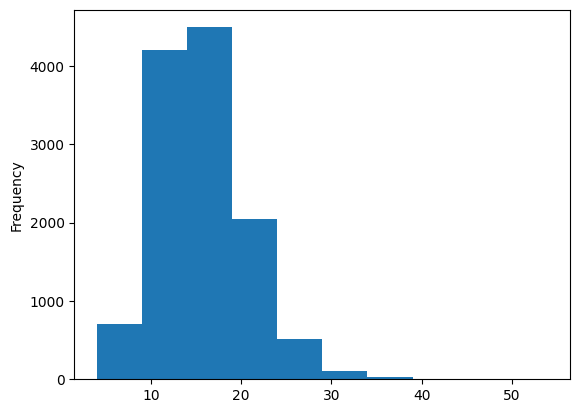

In [6]:
train_data[0].apply(len).plot(kind='hist')

In [7]:
# input_ids：字的编码
# token_type_ids：标识是第一个句子还是第二个句子
# attention_mask：标识是不是填充

In [11]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base")

train_encoding = tokenizer(list(x_train), truncation=True, padding=True, max_length=30)
test_encoding = tokenizer(list(x_test), truncation=True, padding=True, max_length=30)

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/343 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
# 数据集读取
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # 读取单个样本
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = NewsDataset(train_encoding, train_label)
test_dataset = NewsDataset(test_encoding, test_label)

In [13]:
train_dataset[1]

{'input_ids': tensor([ 101, 5543, 1415, 6444, 1168, 3777, 1298, 3696, 4495, 4692, 4692, 3221,
          679, 3221, 1762, 3064, 3123, 2207, 5799, 2376, 2564, 1920, 1346, 5440,
          102,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0]),
 'labels': tensor(9)}

In [14]:
# 精度计算
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('/home/lyz/hf-models/hfl/chinese-macbert-base/', num_labels=12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# 训练函数
def train(model, train_loader, epoch):
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for batch in train_loader:
        # 正向传播
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # 反向梯度信息
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 参数更新
        optim.step()
        # scheduler.step()

        iter_num += 1
        if(iter_num % 100 == 0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))

    print("Epoch: %d, Average training loss: %.4f" % (epoch, total_train_loss/len(train_loader)))


def validation(model, val_dataloader):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in val_dataloader:
        with torch.no_grad():
            # 正常传播
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f" % (total_eval_loss/len(val_dataloader)))
    print("-------------------------------")

In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

fold = 0
for train_idx, val_idx in kf.split(train_data[0].values, train_data[1].values,):
    print(train_idx)
    train_text = train_data[0].iloc[train_idx]
    val_text = train_data[0].iloc[train_idx]

    train_label = train_data[1].iloc[train_idx].values
    val_label = train_data[1].iloc[train_idx].values

    train_encoding = tokenizer(list(train_text), truncation=True, padding=True, max_length=30)
    val_encoding = tokenizer(list(val_text), truncation=True, padding=True, max_length=30)

    # 默认是没有数据扩增，文本默认是没有变换的操作
    train_dataset = NewsDataset(train_encoding, train_label)
    val_dataset = NewsDataset(val_encoding, val_label)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

    # 加载每折的模型
    model = AutoModelForSequenceClassification.from_pretrained('/home/lyz/hf-models/hfl/chinese-macbert-base/', num_labels=12)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 优化方法
    optim = AdamW(model.parameters(), lr=1e-5)
    total_steps = len(train_loader) * 1
    scheduler = get_linear_schedule_with_warmup(optim,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)

    for epoch in range(5):
        train(model, train_loader, epoch)
        validation(model, val_dataloader)

    torch.save(model.state_dict(), 'model_' + str(fold) + '.pt')

    fold += 1

[ 2420  2421  2422 ... 12097 12098 12099]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoth: 0, iter_num: 100, loss: 1.1115, 16.53%
epoth: 0, iter_num: 200, loss: 0.2293, 33.06%
epoth: 0, iter_num: 300, loss: 0.1624, 49.59%
epoth: 0, iter_num: 400, loss: 0.0733, 66.12%
epoth: 0, iter_num: 500, loss: 0.6314, 82.64%
epoth: 0, iter_num: 600, loss: 0.1678, 99.17%
Epoch: 0, Average training loss: 0.6458
Accuracy: 0.9524
Average testing loss: 0.1868
-------------------------------
epoth: 1, iter_num: 100, loss: 0.0242, 16.53%
epoth: 1, iter_num: 200, loss: 0.0624, 33.06%
epoth: 1, iter_num: 300, loss: 0.4115, 49.59%
epoth: 1, iter_num: 400, loss: 0.0894, 66.12%
epoth: 1, iter_num: 500, loss: 0.0975, 82.64%
epoth: 1, iter_num: 600, loss: 0.2471, 99.17%
Epoch: 1, Average training loss: 0.2083
Accuracy: 0.9661
Average testing loss: 0.1270
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0778, 16.53%
epoth: 2, iter_num: 200, loss: 0.1011, 33.06%
epoth: 2, iter_num: 300, loss: 0.0053, 49.59%
epoth: 2, iter_num: 400, loss: 0.5822, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 1.2580, 16.53%
epoth: 0, iter_num: 200, loss: 0.2437, 33.06%
epoth: 0, iter_num: 300, loss: 0.3388, 49.59%
epoth: 0, iter_num: 400, loss: 0.7418, 66.12%
epoth: 0, iter_num: 500, loss: 0.0569, 82.64%
epoth: 0, iter_num: 600, loss: 0.2372, 99.17%
Epoch: 0, Average training loss: 0.6908
Accuracy: 0.9503
Average testing loss: 0.1908
-------------------------------
epoth: 1, iter_num: 100, loss: 0.5731, 16.53%
epoth: 1, iter_num: 200, loss: 0.1217, 33.06%
epoth: 1, iter_num: 300, loss: 0.0502, 49.59%
epoth: 1, iter_num: 400, loss: 0.0521, 66.12%
epoth: 1, iter_num: 500, loss: 0.0474, 82.64%
epoth: 1, iter_num: 600, loss: 0.1360, 99.17%
Epoch: 1, Average training loss: 0.2031
Accuracy: 0.9675
Average testing loss: 0.1253
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0552, 16.53%
epoth: 2, iter_num: 200, loss: 0.2441, 33.06%
epoth: 2, iter_num: 300, loss: 0.0127, 49.59%
epoth: 2, iter_num: 400, loss: 0.0183, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 1.3035, 16.53%
epoth: 0, iter_num: 200, loss: 0.3220, 33.06%
epoth: 0, iter_num: 300, loss: 0.3904, 49.59%
epoth: 0, iter_num: 400, loss: 0.1374, 66.12%
epoth: 0, iter_num: 500, loss: 0.2440, 82.64%
epoth: 0, iter_num: 600, loss: 0.5004, 99.17%
Epoch: 0, Average training loss: 0.6785
Accuracy: 0.9463
Average testing loss: 0.1950
-------------------------------
epoth: 1, iter_num: 100, loss: 0.0323, 16.53%
epoth: 1, iter_num: 200, loss: 0.2680, 33.06%
epoth: 1, iter_num: 300, loss: 0.4692, 49.59%
epoth: 1, iter_num: 400, loss: 0.0191, 66.12%
epoth: 1, iter_num: 500, loss: 0.0557, 82.64%
epoth: 1, iter_num: 600, loss: 0.0096, 99.17%
Epoch: 1, Average training loss: 0.2086
Accuracy: 0.9721
Average testing loss: 0.1015
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0647, 16.53%
epoth: 2, iter_num: 200, loss: 0.2366, 33.06%
epoth: 2, iter_num: 300, loss: 0.0160, 49.59%
epoth: 2, iter_num: 400, loss: 0.0092, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 1.1786, 16.53%
epoth: 0, iter_num: 200, loss: 0.5009, 33.06%
epoth: 0, iter_num: 300, loss: 0.4799, 49.59%
epoth: 0, iter_num: 400, loss: 0.4326, 66.12%
epoth: 0, iter_num: 500, loss: 0.0712, 82.64%
epoth: 0, iter_num: 600, loss: 0.3000, 99.17%
Epoch: 0, Average training loss: 0.6369
Accuracy: 0.9506
Average testing loss: 0.1808
-------------------------------
epoth: 1, iter_num: 100, loss: 0.2272, 16.53%
epoth: 1, iter_num: 200, loss: 0.2808, 33.06%
epoth: 1, iter_num: 300, loss: 0.0485, 49.59%
epoth: 1, iter_num: 400, loss: 0.5745, 66.12%
epoth: 1, iter_num: 500, loss: 0.3021, 82.64%
epoth: 1, iter_num: 600, loss: 0.0438, 99.17%
Epoch: 1, Average training loss: 0.1879
Accuracy: 0.9719
Average testing loss: 0.1077
-------------------------------
epoth: 2, iter_num: 100, loss: 0.1408, 16.53%
epoth: 2, iter_num: 200, loss: 0.0121, 33.06%
epoth: 2, iter_num: 300, loss: 0.0064, 49.59%
epoth: 2, iter_num: 400, loss: 0.1176, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 0.9187, 16.53%
epoth: 0, iter_num: 200, loss: 0.3077, 33.06%
epoth: 0, iter_num: 300, loss: 0.6920, 49.59%
epoth: 0, iter_num: 400, loss: 0.3029, 66.12%
epoth: 0, iter_num: 500, loss: 0.2119, 82.64%
epoth: 0, iter_num: 600, loss: 0.0177, 99.17%
Epoch: 0, Average training loss: 0.4768
Accuracy: 0.9741
Average testing loss: 0.1047
-------------------------------
epoth: 1, iter_num: 100, loss: 0.4461, 16.53%
epoth: 1, iter_num: 200, loss: 0.0104, 33.06%
epoth: 1, iter_num: 300, loss: 0.1575, 49.59%
epoth: 1, iter_num: 400, loss: 0.0065, 66.12%
epoth: 1, iter_num: 500, loss: 0.2315, 82.64%
epoth: 1, iter_num: 600, loss: 0.0046, 99.17%
Epoch: 1, Average training loss: 0.1033
Accuracy: 0.9867
Average testing loss: 0.0517
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0052, 16.53%
epoth: 2, iter_num: 200, loss: 0.0036, 33.06%
epoth: 2, iter_num: 300, loss: 0.0172, 49.59%
epoth: 2, iter_num: 400, loss: 0.5190, 66.12%
epoth: 2, iter_num: 500, los

In [21]:
test_encoding = tokenizer(list(test_data[0]), truncation=True, padding=True, max_length=30)
test_dataset = NewsDataset(test_encoding, [0] * len(test_data))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def prediction(model, test_dataloader):
    model.eval()
    pred = []
    for batch in test_dataloader:
        with torch.no_grad():
            # 正常传播
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]

        logits = logits.detach().cpu().numpy()
        pred.append(logits)
        # pred += list(np.argmax(logits, axis=1).flatten())

    return np.vstack(pred)

In [22]:
pred = np.zeros((3000, 12))
for path in ['model_0.pt', 'model_1.pt', 'model_2.pt', 'model_3.pt', 'model_4.pt']:
    # model = AutoModelForSequenceClassification.from_pretrained('/home/lyz/huggingface模型下载/hfl/chinese-macbert-large/', num_labels=12)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    model.load_state_dict(torch.load(path))
    pred += prediction(model, test_dataloader)

In [23]:
pd.DataFrame({
    'ID': range(1, len(test_data) + 1),
    'Target': [lbl[x] for x in pred.argmax(1)],
}).to_csv('nlp_submit.csv', index=None)